In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn import init
from tabulate import tabulate

from focal_Loss import *
from utility import *

# Read dataset

In [2]:
data_name = "SC500"
# data_name = "CFL30"
data_path = "DataSet"+data_name+"/"
split = [0.70,0.15,0.15]

dataSet = load_data(data_path)

data_train,data_validation,data_test = torch.utils.data.random_split(dataSet,[int(len(dataSet) * s) for s in split])
# print(dataSet[0]['A'])
# for l in dataSet[0]['A']:
#     for i in l:
#         print(int(i!=0),end = '\t')
#     print()

# data_train_X,data_train_Y,data_validation_X,data_validation_Y,data_test_X,data_test_Y,A = load_data()
# print(data_train_X.shape)
# print(data_train_Y.shape)
# print(A.shape)
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:23<00:00, 12.74it/s]


# GCN

In [7]:
class simpleMLP(nn.Module):
    def __init__(self, input_size, out_size,activate = nn.ReLU()):
        super(simpleMLP, self).__init__()
        self.linear = nn.Linear(input_size, out_size)
        self.activate = activate
        
    def forward(self, x):
        x = self.linear(x)
        x = self.activate(x)
        return x
    
# class GNN(nn.Module):
#     def __init__(self, input_size,hidden_size,nb_MLP):
#         super(GNN,self).__init__()
#         self.mlp = nn.ModuleList(
#             [simpleMLP(input_size, hidden_size)]+[simpleMLP(hidden_size, hidden_size) for i in range(nb_MLP - 1)]   
#         )
    
#     def forward(self, x, A):
#         for mlp_module in self.mlp:
#             x = mlp_module(x)
#             x = A @ x
#         return x
    
class GNN(nn.Module):
    def __init__(self, input_size,hidden_size,nb_MLP):
        super(GNN,self).__init__()
        self.input_mlp = simpleMLP(input_size, hidden_size)
        self.mlp = nn.ModuleList(
            [simpleMLP(hidden_size, hidden_size) for i in range(nb_MLP - 1)]   
        )
    
    def forward(self, x, A):
        x = self.input_mlp(x)
        x = A @ x
        for mlp_module in self.mlp:
            x = mlp_module(x)
            x = A @ x
        return x
    
class VariablePredictor(nn.Module):
    def __init__(self, input_size,hidden_size,nb_MLP):
        super(VariablePredictor,self).__init__()
        self.GNN = GNN(input_size,hidden_size,nb_MLP)
        self.outlayer = simpleMLP(hidden_size,1,nn.Sigmoid())    
    
    def forward(self,x,A):
        x = self.GNN(x,A)
        return self.outlayer(x)




class VariablePredictor_OnlyOutLayer(nn.Module):
    def __init__(self, input_size,hidden_size,nb_MLP):
        super(VariablePredictor_OnlyOutLayer,self).__init__()
#         self.GNN = GNN(input_size,hidden_size,nb_MLP)
        self.outlayer = simpleMLP(hidden_size,1,nn.Sigmoid())    
    
    def forward(self,x,A):
#         x = self.GNN(x,A)
        return self.outlayer(x)        

## Train


In [8]:
def train(model, x, y,A, optimizer,criterion):
    optimizer.zero_grad()
    output = model(x,A)[:len(y)].squeeze(dim=-1)
#     print("output",output)
    loss =criterion(output,y)
#     print("loss",loss)
    loss.backward()
    optimizer.step()

    return loss, output


def valide(model,criterion,data_validation,proportion = 0.7):
        vloss = []
        accuracy_value = []
        accuracy_instance = []
        
        accuracy_one = []
        accuracy_one_predict = []
        nb_predict_one = []
        nb_one = []
        
        accuracy_zero = []
        accuracy_zero_predict = []
        nb_zero = []
        nb_predict_zero = []
        
        accuracy_fixe_one = []
        accuracy_fixe_zero = []  
        accuracy_fixe = []
        
        data_size = len(data_validation)
        for i in range(data_size):
            if device == torch.device("cuda"):
                inputs, labels = data_validation[i][0],data_validation[i][1]#torch.from_numpy(data_train[i]['X']).float(),torch.from_numpy(data_train[i]['Y']).type(torch.FloatTensor).float()
                A =data_validation[i][2]# torch.from_numpy(data_train[i]['A']).float()
            else:
                inputs, labels =torch.from_numpy(data_train[i]['X']).float(),torch.from_numpy(data_train[i]['Y']).type(torch.FloatTensor).float()
                A =torch.from_numpy(data_train[i]['A']).float()
            predictions = model(inputs,A)[:len(labels)].squeeze(dim=-1)
            loss =criterion(predictions,labels)
            A = A.cpu()
            labels = labels.cpu()
            predictions = predictions.cpu()
            
            nb_one_total = torch.sum(torch.where(labels == 1,1,0))
            nb_zero_total = (len(labels) - nb_one_total)
            aux= torch.Tensor([0.5])
            y_hat = (predictions > aux).float() * 1
            is_equal = torch.where(y_hat == labels,1,0)
            vloss.append(loss.cpu().detach().numpy())
            accuracy_value.append(is_equal.cpu().sum().detach().numpy()/
                           len(labels))
            accuracy_instance.append(int(accuracy_value[-1]==1))
            #accuracy proportion
            predictions_abs =  np.abs(0.5 - predictions.detach().numpy())
            thresholds = abs(np.sort(-predictions_abs))[int(proportion * len(predictions.cpu().detach().numpy()))- 1]
#             thresholds_low = np.sort(predictions_abs)[int(proportion_low * nb_zero_total]
#             thresholds_up = abs(np.sort(-predictions_abs))[int(proportion_up * nb_one_total)]
            
            #accuracy for differents labels(0 or 1)
            nb_one_fixe = 0
            nb_zero_fixe = 0
            nb_correct_one = 0
            nb_correct_zero = 0
            nb_correct_fixe_one = 0
            nb_correct_fixe_zero = 0
            nb_correct_fixe = 0
            nb_fixe = 0 
            for j,v in enumerate(is_equal):
                if labels[j] == 1:
                    nb_correct_one += v
                else:
                    nb_correct_zero += v

                if predictions_abs[j] >= thresholds:             
                    if labels[j]:
                        nb_correct_fixe_one += v
                    else:
                        nb_correct_fixe_zero += v
                        
                    if y_hat[j]:
                        nb_one_fixe += 1
                    else:
                        nb_zero_fixe += 1

#                 if predictions_abs[j] <= thresholds_low:
#                     if labels[j] == 0:
#                         nb_correct_fixe_zero += v
#                     nb_zero_to_fixe += 1
#                 if predictions_abs[j] >= thresholds_up:
#                     if labels[j] == 1:
#                         nb_correct_fixe_one += v
#                     nb_one_to_fixe += 1
                    
            nb_one_total = torch.sum(torch.where(labels == 1,1,0))
            nb_one_predict = torch.sum(torch.where(y_hat == 1,1,0))
            accuracy_one.append((nb_correct_one/nb_one_total))
            accuracy_one_predict.append((nb_correct_one/nb_one_predict) if nb_one_predict > 0 else 0)
            nb_predict_one.append(nb_one_predict)
            nb_one.append(nb_one_total)
            
            nb_zero_predict = (len(labels) - nb_one_predict)
            accuracy_zero.append((nb_correct_zero/nb_zero_total))
            accuracy_zero_predict.append((nb_correct_zero/nb_zero_predict) if nb_zero_predict > 0 else 0)
            nb_predict_zero.append(nb_zero_predict)
            nb_zero.append(nb_zero_total)
            
            accuracy_fixe.append((nb_correct_fixe_one+nb_correct_fixe_zero)/(nb_one_fixe+nb_zero_fixe))
            accuracy_fixe_one.append(nb_correct_fixe_one/nb_one_fixe if nb_one_fixe>0 else 0)
            accuracy_fixe_zero.append(nb_correct_fixe_zero/nb_zero_fixe if nb_zero_fixe>0 else 0)
            
        #     print(nb_correct_fixe.cpu(),nb_var_fixe)
        #         print(labels,"\n",predictions)
        #         print(labels[0:10],y_hat[0:10])
        print("Loss = %f,Accuracy_value = %f,Accuracy_instance = %f"\
              %(np.mean(vloss),np.mean(accuracy_value),np.sum(accuracy_instance)/len(accuracy_instance)))
        print("Label_One_Predict_One = %f,Predict_One_Label_One = %f,Nombre_Predict_One = %f,Nombre_One_Mean = %f"\
              %(np.mean(accuracy_one),np.mean(accuracy_one_predict),np.mean(nb_predict_one),np.mean(nb_one)))
        print("Label_Zero_Predict_Zero = %f,Label_Zero_Predict_Zero = %f,Nombre_Predict_Zero = %f,Nombre_Zero_Mean = %f"\
              %(np.mean(accuracy_zero),np.mean(accuracy_zero_predict),np.mean(nb_predict_zero),np.mean(nb_zero)))
        print("Accuracy_fixe_mean = %f,Accuracy_fixe_one = %f,Accuracy_fixe_zero = %f"\
              %(np.mean(accuracy_fixe),np.mean(accuracy_fixe_one),np.mean(accuracy_fixe_zero)))
        return np.mean(accuracy_value),np.sum(accuracy_instance)/len(accuracy_instance),np.mean(accuracy_fixe_one),np.mean(accuracy_fixe_zero)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(device)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
EPOCHS = 300
nb_mlp = 1
gam = 0.5
# criterion = nn.BCELoss()
criterion = FocalLoss(gamma=gam)
# torch.cuda.get_device_name(device)
# print(torch.cuda.get_device_name(next(net.parameters()).device))


cuda


In [27]:
if device == torch.device("cuda"):
    print(device)
#     torch.cuda.empty_cache()
    data_train_gpu = []
    for i in range(len(data_train)):
        inputs, labels = torch.from_numpy(data_train[i]['X']).float(),torch.from_numpy(data_train[i]['Y']).type(torch.FloatTensor).float()
        A = torch.from_numpy(data_train[i]['A']).float()
        inputs = inputs.to(device)
        labels = labels.to(device)
        A = A.to(device)
        data_train_gpu.append([inputs,labels,A])
    data_valide_gpu = []
    for i in range(len(data_validation)):
        inputs, labels = torch.from_numpy(data_validation[i]['X']).float(),torch.from_numpy(data_validation[i]['Y']).type(torch.FloatTensor).float()
        A = torch.from_numpy(data_validation[i]['A']).float()
        inputs = inputs.to(device)
        labels = labels.to(device)
        A = A.to(device)
        data_valide_gpu.append([inputs,labels,A])
    data_test_gpu = []
    for i in range(len(data_test)):
        inputs, labels = torch.from_numpy(data_test[i]['X']).float(),torch.from_numpy(data_test[i]['Y']).type(torch.FloatTensor).float()
        A = torch.from_numpy(data_test[i]['A']).float()
        inputs = inputs.to(device)
        labels = labels.to(device)
        A = A.to(device)
        data_test_gpu.append([inputs,labels,A])

cuda


In [29]:
# net = VariablePredictor(24,50,nb_mlp)
# net.to(device)
# optm = Adam(net.parameters(), lr = 0.0001)

# hist = []

for epoch in tqdm(range(EPOCHS)):
    #validation
    if epoch % 50 == 0:
        if device == torch.device("cuda"):
            v = [valide(net,criterion,data_valide_gpu,0.7)]
            hist.append([epoch]+v)
        else:
            valide(net,criterion,data_validation,0.7)
    #train
    for i in range(len(data_train)):
        if device == torch.device("cuda"):
            train_inputs, train_labels = data_train_gpu[i][0],data_train_gpu[i][1]#torch.from_numpy(data_train[i]['X']).float(),torch.from_numpy(data_train[i]['Y']).type(torch.FloatTensor).float()
            A =data_train_gpu[i][2]# torch.from_numpy(data_train[i]['A']).float()
        else:
            train_inputs, train_labels = torch.from_numpy(data_train[i]['X']).float(),torch.from_numpy(data_train[i]['Y']).type(torch.FloatTensor).float()
            A = torch.from_numpy(data_train[i]['A']).float()
        loss, predictions = train(net,train_inputs,train_labels,A,optm, criterion)

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Loss = 0.123449,Accuracy_value = 0.995289,Accuracy_instance = 0.711111
Label_One_Predict_One = 0.951483,Predict_One_Label_One = 0.948693,Nombre_Predict_One = 22.444444,Nombre_One_Mean = 22.400000
Label_Zero_Predict_Zero = 0.997475,Label_Zero_Predict_Zero = 0.997567,Nombre_Predict_Zero = 477.555556,Nombre_Zero_Mean = 477.600000
Accuracy_fixe_mean = 0.998443,Accuracy_fixe_one = 0.967562,Accuracy_fixe_zero = 0.999606


 25%|████████████████████▎                                                            | 50/200 [00:20<00:58,  2.58it/s]

Loss = 0.123449,Accuracy_value = 0.995289,Accuracy_instance = 0.711111
Label_One_Predict_One = 0.951483,Predict_One_Label_One = 0.948693,Nombre_Predict_One = 22.444444,Nombre_One_Mean = 22.400000
Label_Zero_Predict_Zero = 0.997475,Label_Zero_Predict_Zero = 0.997567,Nombre_Predict_Zero = 477.555556,Nombre_Zero_Mean = 477.600000
Accuracy_fixe_mean = 0.997562,Accuracy_fixe_one = 0.962296,Accuracy_fixe_zero = 0.999038


 50%|████████████████████████████████████████                                        | 100/200 [00:40<00:39,  2.54it/s]

Loss = 0.123449,Accuracy_value = 0.995289,Accuracy_instance = 0.711111
Label_One_Predict_One = 0.951483,Predict_One_Label_One = 0.948693,Nombre_Predict_One = 22.444444,Nombre_One_Mean = 22.400000
Label_Zero_Predict_Zero = 0.997475,Label_Zero_Predict_Zero = 0.997567,Nombre_Predict_Zero = 477.555556,Nombre_Zero_Mean = 477.600000
Accuracy_fixe_mean = 0.997259,Accuracy_fixe_one = 0.961265,Accuracy_fixe_zero = 0.998803


 75%|████████████████████████████████████████████████████████████                    | 150/200 [01:01<00:19,  2.55it/s]

Loss = 0.123449,Accuracy_value = 0.995289,Accuracy_instance = 0.711111
Label_One_Predict_One = 0.951483,Predict_One_Label_One = 0.948693,Nombre_Predict_One = 22.444444,Nombre_One_Mean = 22.400000
Label_Zero_Predict_Zero = 0.997475,Label_Zero_Predict_Zero = 0.997567,Nombre_Predict_Zero = 477.555556,Nombre_Zero_Mean = 477.600000
Accuracy_fixe_mean = 0.996996,Accuracy_fixe_one = 0.958721,Accuracy_fixe_zero = 0.998709


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:22<00:00,  2.43it/s]


In [65]:
print(hist)
histFL = hist

[[0, (0.08426666666666666, 0.0, 0.0005924316433568795, 0.17291545470555622)], [50, (0.9950222222222223, 0.6222222222222222, 0.022222222222222223, 0.999746)], [100, (0.995288888888889, 0.6888888888888889, 0.0, 0.9997472)], [150, (0.995288888888889, 0.6888888888888889, 0.0, 0.9997494)], [200, (0.9952000000000001, 0.6444444444444445, 0.0, 0.99974906)], [250, (0.9952, 0.6444444444444445, 0.022222222222222223, 0.99968517)], [300, (0.995288888888889, 0.6444444444444445, 0.2222222222222222, 0.99955624)], [350, (0.995288888888889, 0.6444444444444445, 0.3333333333333333, 0.999239)], [400, (0.995288888888889, 0.6444444444444445, 0.3333333333333333, 0.9993014)], [450, (0.995288888888889, 0.6444444444444445, 0.3333333333333333, 0.99924314)]]


In [67]:
histBCE
histFL

[[0, (0.08426666666666666, 0.0, 0.0005924316433568795, 0.17291545470555622)],
 [50,
  (0.9950222222222223, 0.6222222222222222, 0.022222222222222223, 0.999746)],
 [100, (0.995288888888889, 0.6888888888888889, 0.0, 0.9997472)],
 [150, (0.995288888888889, 0.6888888888888889, 0.0, 0.9997494)],
 [200, (0.9952000000000001, 0.6444444444444445, 0.0, 0.99974906)],
 [250, (0.9952, 0.6444444444444445, 0.022222222222222223, 0.99968517)],
 [300,
  (0.995288888888889, 0.6444444444444445, 0.2222222222222222, 0.99955624)],
 [350, (0.995288888888889, 0.6444444444444445, 0.3333333333333333, 0.999239)],
 [400, (0.995288888888889, 0.6444444444444445, 0.3333333333333333, 0.9993014)],
 [450,
  (0.995288888888889, 0.6444444444444445, 0.3333333333333333, 0.99924314)]]

In [31]:
_=valide(net,criterion,data_test_gpu,proportion = 0.9)

Loss = 0.124041,Accuracy_value = 0.992444,Accuracy_instance = 0.622222
Label_One_Predict_One = 0.917331,Predict_One_Label_One = 0.920504,Nombre_Predict_One = 21.044444,Nombre_One_Mean = 21.177778
Label_Zero_Predict_Zero = 0.996168,Label_Zero_Predict_Zero = 0.995893,Nombre_Predict_Zero = 478.955556,Nombre_Zero_Mean = 478.822222
Accuracy_fixe_mean = 0.995849,Accuracy_fixe_one = 0.938945,Accuracy_fixe_zero = 0.998332


In [68]:
_=valide(net,criterion,data_test_gpu,proportion = 0.8)

Loss = 0.042933,Accuracy_value = 0.993422,Accuracy_instance = 0.555556
Label_One_Predict_One = 0.925031,Predict_One_Label_One = 0.927614,Nombre_Predict_One = 22.355556,Nombre_One_Mean = 22.444444
Label_Zero_Predict_Zero = 0.996638,Label_Zero_Predict_Zero = 0.996457,Nombre_Predict_Zero = 477.644444,Nombre_Zero_Mean = 477.555556
Accuracy_fixe_mean = 0.999224,Accuracy_fixe_one = 0.400000,Accuracy_fixe_zero = 0.999223


(0.9934222222222222, 0.5555555555555556, 0.4, 0.9992228)

## Test

In [32]:
# nb_mlp = 1
# net = VariablePredictor(24,50,nb_mlp)
# net.to(device)
# data_name = "SC100"

model_path = "model/"+data_name+"_MLP"+nb_mlp.__str__()+"Gamma0.5_Epoch300"
torch.save(net.state_dict(),model_path)


In [ ]:
# model_path = "model/SC1000_MLP3_NoA"
model_path = "model/CFL30_MLP3_NoA"
torch.save(net.state_dict(),model_path)

In [79]:
# model_path = "model/SC1000_MLP1"
model = VariablePredictor(24,50,1).to(device)
model.load_state_dict(torch.load(model_path))
valide(model,criterion,data_test_gpu,proportion = 0.8)

Loss = 0.086726,Accuracy_value = 0.993511,Accuracy_instance = 0.600000
Label_One_Predict_One = 0.927759,Predict_One_Label_One = 0.927113,Nombre_Predict_One = 22.444444,Nombre_One_Mean = 22.444444
Label_Zero_Predict_Zero = 0.996592,Label_Zero_Predict_Zero = 0.996596,Nombre_Predict_Zero = 477.555556,Nombre_Zero_Mean = 477.555556
Accuracy_fixe_mean = 0.996271,Accuracy_fixe_one = 0.928301,Accuracy_fixe_zero = 0.999600


(0.9935111111111112, 0.6, 0.92830133, 0.99960005)

In [ ]:
# model_path = "model/SC1000_NoCov_OnlyOutLayer"
model_path = "model/CFL30_NoCov_OnlyOutLayer"
model = VariablePredictor_OnlyOutLayer(24,24,nb_mlp).to(device)
model.load_state_dict(torch.load(model_path))
valide(model,criterion,data_test,proportion = 0.7)

In [ ]:
model = VariablePredictor(24,50,nb_mlp).to(device)


# Analyse


In [15]:
def predict(model,data_validation):
        predictions_values = []
        is_predict_correct = []
        data_size = len(data_validation)
        y_hats = []
        labels = []
        for i in range(data_size):
            if data_validation[0][0].device == "cpu":
                inputs, label = torch.from_numpy(data_validation[i]['X']).float(),\
                                torch.from_numpy(data_validation[i]['Y']).type(torch.FloatTensor).float()
                A = torch.from_numpy(data_validation[i]['A']).float()
                inputs = inputs.to(device)
                label = label.to(device)
                A = A.to(device)
            else:
                inputs, label = data_validation[i][0],data_validation[i][1]
                A =data_validation[i][2]
            predictions = model(inputs,A)[:len(label)].squeeze(dim=-1)
            label = label.cpu()
            predictions = predictions.cpu()
            predictions_values.append(predictions)

            aux= torch.Tensor([0.5])
            y_hat = (predictions > aux).float() * 1
            is_equal = torch.where(y_hat == label,1,0)
            is_predict_correct.append(is_equal)
            y_hats.append(y_hat)
            labels.append(label)
        return predictions_values,labels,y_hats,is_predict_correct

def fixe_proportionally(predictions_values,labels,y_hat,is_predict_correct,proportion = 0.7): 
        hist_nb_one_fixe = []
        hist_nb_zero_fixe = []
        accuracy_fixe_one = []
        accuracy_fixe_zero = []  
        
        data_size = len(predictions_values)
        for i in range(data_size):
            problem_size = len(y_hat[i])
            nb_one_total = torch.sum(torch.where(labels[i] == 1,1,0))
            nb_zero_total = (problem_size - nb_one_total)
            aux= torch.Tensor([0.5])
            predictions_norm =  np.abs(0.5 - predictions_values[i].detach().numpy())
            thresholds = abs(np.sort(-predictions_norm))[int(proportion * problem_size)- 1]
            
            nb_one_fixe = 0
            nb_zero_fixe = 0
            nb_correct_fixe_one = 0
            nb_correct_fixe_zero = 0
            nb_correct_fixe = 0
            nb_fixe = 0 
            for j,v in enumerate(is_predict_correct[i]):
                if predictions_norm[j] >= thresholds:             
                    if labels[i][j]:
                        nb_correct_fixe_one += v
                    else:
                        nb_correct_fixe_zero += v
                        
                    if y_hat[i][j]:
                        nb_one_fixe += 1
                    else:
                        nb_zero_fixe += 1
            hist_nb_one_fixe.append(nb_one_fixe)
            hist_nb_zero_fixe.append(nb_zero_fixe)
            accuracy_fixe_one.append(nb_correct_fixe_one/nb_one_fixe if nb_one_fixe>0 else 0)
            accuracy_fixe_zero.append(nb_correct_fixe_zero/nb_zero_fixe if nb_zero_fixe>0 else 0)
        return np.mean(accuracy_fixe_one),np.mean(hist_nb_one_fixe),np.mean(accuracy_fixe_zero),np.mean(hist_nb_zero_fixe)
    
def fixe_one_epsilon(predictions_values,y_hats,labels,e = 0.01):
    nbs_fixe = []
    accs_fixe = []
    props = []
    data_size = len(data_validation)
    thresholds = 1 - e
    for i in range(data_size):
        problem_size = len(labels[i])
        nb_fixe = 0
        nb_correct_fixe = 0
        nb_one_total = torch.sum(torch.where(labels[i] == 1,1,0))
        for j in range(problem_size):
            if predictions[i][j] >= thresholds:  
                nb_fixe += 1
                if y_hats[i][j] and labels[i][j]:
                    nb_correct_fixe += 1
        nbs_fixe.append(nb_fixe)
        accs_fixe.append(nb_correct_fixe/nb_fixe if nb_fixe > 0 else 0)        
        props.append(nb_correct_fixe/nb_one_total)
    return np.mean(accs_fixe),np.mean(nbs_fixe),np.mean(props)

In [58]:
# model_name = data_name+"_MLP"+nb_mlp.__str__()+"Gamma0.5"
nb_mlp = 3
data_name = "SC1000"
model_name = data_name+"_MLP"+nb_mlp.__str__()
model_path = "model/"+model_name
model = VariablePredictor(24,50,nb_mlp).to(device)
model.load_state_dict(torch.load(model_path))
predictions,labels,y_hats,is_corrects = predict(model,data_test_gpu)


  Epsilon    Accuracy_fixe_one    Number_fixe_one    Correct_One/Total_One
---------  -------------------  -----------------  -----------------------
     0               0                  0                      0
     0.01            0                  0                      0
     0.02            0                  0                      0
     0.03            0                  0                      0
     0.04            0                  0                      0
     0.05            0                  0                      0
     0.06            0                  0                      0
     0.07            0                  0                      0
     0.08            0                  0                      0
     0.09            0                  0                      0
     0.1             0                  0                      0
     0.11            0.0222222          0.0222222              0.000766284
     0.12            0.0222222          0.0222222           

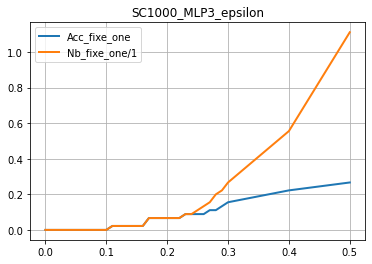

In [59]:
test_epsilon = []
epsilons = [0.01 * i for i in range(0,30,1)]+[0.01 * i for i in range(30,51,10)]
for e in epsilons:
    test_epsilon.append([e]+list(fixe_one_epsilon(predictions,y_hats,labels,e)))
print(tabulate(test_epsilon, headers=["Epsilon", "Accuracy_fixe_one", "Number_fixe_one","Correct_One/Total_One"]))

fig, ax = plt.subplots()
values = np.array(test_epsilon).T
acc_one,= ax.plot(values[0], values[1], linewidth=2.0,label=r'Acc_fixe_one')
maxv = int(max(values[2]))
nb_one,= ax.plot(values[0], values[2]/maxv, linewidth=2.0,label=r'Nb_fixe_one/'+maxv.__str__())
plt.legend(handles=[acc_one,nb_one],loc="best",)
plt.title(model_name+"_epsilon")
plt.savefig("image/"+model_name+"_epsilon.png")
plt.grid()
plt.show()


  Proportion    Accuracy_fixe_one    Number_fixe_one    Accuracy_fixe_zero    Number_fixe_zero
------------  -------------------  -----------------  --------------------  ------------------
        0.1             0                  0                      0.999906             254.644
        0.2             0                  0                      0.999906             275.867
        0.3             0                  0                      0.999906             294.156
        0.4             0                  0                      0.999906             323.756
        0.5             0                  0                      0.999817             354.489
        0.6             0                  0                      0.999832             375.733
        0.7             0                  0                      0.99978              399.444
        0.8             0                  0                      0.99974              425.556
        0.81            0                  0      

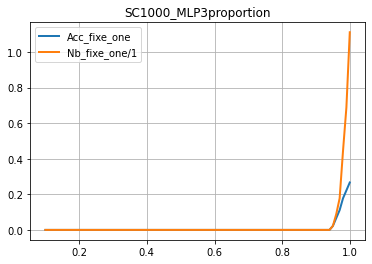

In [60]:
test_values = []
proportions = [0.1 * i for i in range(1,8)]+[0.01 * i for i in range(80,101)]
for p in proportions:
    test_values.append([p]+list(fixe_proportionally(predictions,labels,y_hats,is_corrects,proportion = p)))
    
print(tabulate(test_values, headers=["Proportion", "Accuracy_fixe_one", "Number_fixe_one","Accuracy_fixe_zero", "Number_fixe_zero"]))
fig, ax = plt.subplots()
values = np.array(test_values).T
acc_one,= ax.plot(values[0], values[1], linewidth=2.0,label=r'Acc_fixe_one')
maxv = int(max(values[2]))
nb_one,= ax.plot(values[0], values[2]/maxv, linewidth=2.0,label=r'Nb_fixe_one/'+maxv.__str__())
plt.legend(handles=[acc_one,nb_one],loc="best",)
plt.title(model_name+"proportion")
plt.savefig("image/"+model_name+"_prop.png")
plt.grid()
plt.show()